# BAM File Statistics Analyzer
Abby Chou

#### Properties Analyzed:
* Read Length
* Reference spread (difference between start and end positions on the reference)
* Total Soft Clip, Hard Clip, Insertion, Deletion values (from cigar string)
* Max Insertion, Deletion values from cigar string
* Is A Supplementary Alignment
* Is A Secondary Alignment
* Mapping Quality
* Reverse (Whether it maps to the reverse strand)

## Setup
Requires a Python 3 kernel with pandas, pysam, and matplotlib installed

In [3]:
import pandas as pd
from pysam import AlignmentFile
import matplotlib.pyplot as plt

## Class to parse cigar string

In [2]:
class CigarString:

    CIGAR_OP_CODES = ['M', 'I', 'D', 'N', 'S', 'H', 'P', '=', 'X', 'B']

    def __init__(self, cigartuples):
        self.cigartuples = cigartuples
        self.total = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0, 'B': 0}
        self.max = self.total.copy()
        self.analyze_cigar_string()

    def analyze_cigar_string(self):
        for op, num in self.cigartuples:
            # update stats
            self.total[CigarString.CIGAR_OP_CODES[op]] += num
            if num > self.max[CigarString.CIGAR_OP_CODES[op]]:
                self.max[CigarString.CIGAR_OP_CODES[op]] = num

## Parse Input BAM
Customize path and chromosome!

In [17]:
bam_path = "../cluster/data/HiFi/simple_events_example/used_pbsim3_sus/simple_events.bam"
chr_contig = "NC_000021.9" # replace with None to get reads for all chromosomes

bam = AlignmentFile(bam_path, "rb")
stats = []

for read in bam.fetch(chr_contig):

    cigar = CigarString(read.cigartuples)

    stats.append([
        read.infer_read_length(), 
        read.infer_query_length(),
        cigar.total['S'],
        cigar.total['H'],
        cigar.total['I'],
        cigar.total['D'],
        cigar.max['I'],
        cigar.max['D'],
        read.is_supplementary,
        read.is_secondary, 
        read.mapping_quality, # TODO: SEE WHAT THIS IS
        read.is_reverse,
        ])

df = pd.DataFrame(stats, columns=[
    'len',
    'ref_spread',
    'total_S',
    'total_H',
    'total_I',
    'total_D',
    'max_I',
    'max_D',
    'supplementary',
    'secondary',
    'map_qual',
    'reverse' 
])

## View Results
### Integer-Quantity Properties

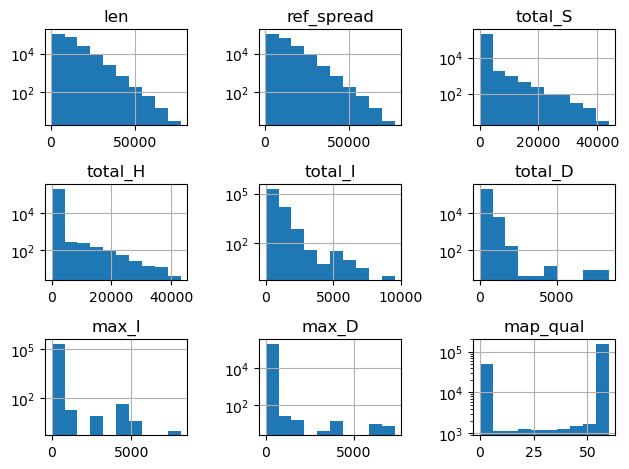

In [18]:
df.hist(log=True, bins=10)
plt.tight_layout()

In [19]:
# select all cols with integer (not boolean) values
df[[
    'len',
    'ref_spread',
    'total_S',
    'total_H',
    'total_I',
    'total_D',
    'max_I',
    'max_D',
    'map_qual',
]].agg(['mean', 'std', 'min', 'max']) # can add min, max, median, etc.

,len,ref_spread,total_S,total_H,total_I,total_D,max_I,max_D,map_qual
mean,9750.358056,9695.796860,373.960958,54.561195,435.647136,278.087192,11.958052,5.220336,45.073699
std,7189.953358,7166.270219,1626.970516,950.879090,348.801476,237.377329,70.211500,72.166273,25.208505
min,385.000000,385.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000
max,77206.000000,77206.000000,44004.000000,43289.000000,9566.000000,8383.000000,8101.000000,7356.000000,60.000000


### Results for Boolean Properties of Reads

array([<AxesSubplot: title={'center': 'supplementary'}>,
       <AxesSubplot: title={'center': 'secondary'}>,
       <AxesSubplot: title={'center': 'reverse'}>], dtype=object)

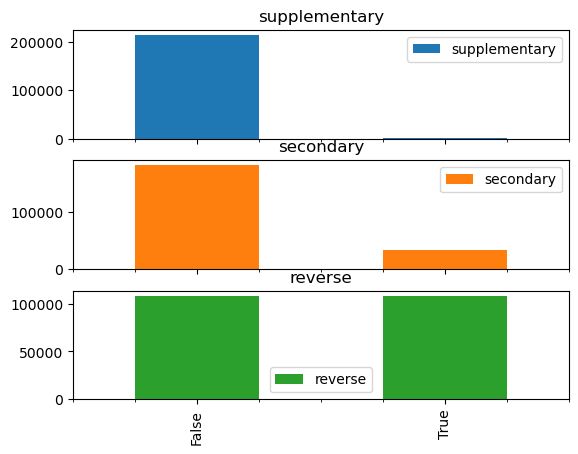

In [20]:
df_bool_only = df[['supplementary', 'secondary', 'reverse']]
bool_only_counts = df_bool_only.apply(pd.value_counts)
bool_only_counts.plot.bar(subplots=True)